In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Mofid

/content/drive/MyDrive/Mofid


In [ ]:
#!unzip train-3.zip

In [ ]:
# Import libraries 
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import glob 
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [ ]:
TRAIN = "/content/drive/MyDrive/Mofid/train-3/"

# Run one example 
dir_list = os.listdir(TRAIN)
dir_list[0:5]

['0000MA.wav', '0003MA.wav', '0004MN.wav', '0005FS.wav', '0006MA.wav']

In [ ]:
# Get the data location for TRAIN
dir_list = os.listdir(TRAIN)

# parse the filename to get the emotions
emotion = []
gender = []
path = []

for i in dir_list:
    # gender
    if i[-6:-5]=='F':
        gender.append('female')
    elif i[-6:-5]=='M':
        gender.append('male')
    
    # emotion
    if i[-5:-4]=='A':
        emotion.append('angry')
    elif i[-5:-4]=='H':
        emotion.append('happy')
    elif i[-5:-4]=='S':
        emotion.append('sad')
    elif i[-5:-4]=='W':
        emotion.append('surprise')
    elif i[-5:-4]=='N':
        emotion.append('neutral')

    path.append(TRAIN + i)

# Now check out the label count distribution 
df = pd.DataFrame(path, columns = ['path'])
df = pd.concat([df, pd.DataFrame(gender, columns = ['gender'])], axis = 1)
df = pd.concat([df, pd.DataFrame(emotion, columns = ['labels'])], axis = 1)
df.head()

,path,gender,labels
0,/content/drive/MyDrive/Mofid/train-3/0000MA.wav,male,angry
1,/content/drive/MyDrive/Mofid/train-3/0003MA.wav,male,angry
2,/content/drive/MyDrive/Mofid/train-3/0004MN.wav,male,neutral
3,/content/drive/MyDrive/Mofid/train-3/0005FS.wav,female,sad
4,/content/drive/MyDrive/Mofid/train-3/0006MA.wav,male,angry


In [ ]:
df.labels.value_counts()

angry       795
neutral     782
sad         329
surprise    163
happy       152
Name: labels, dtype: int64

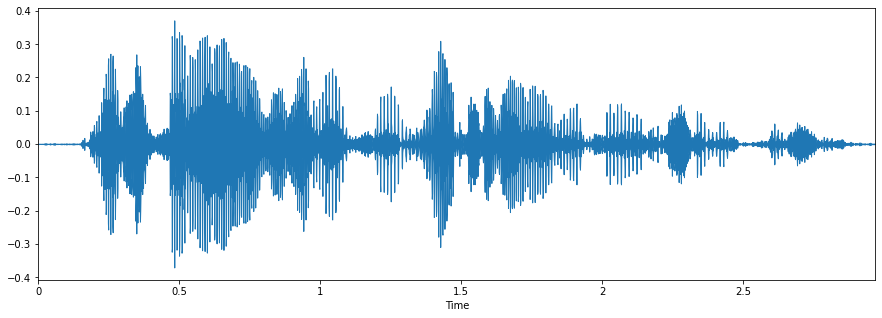

In [ ]:
# use the well known Librosa library for this task 
fname = TRAIN + '0004MN.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

In [ ]:
# Import our libraries
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import pandas as pd
import os
import IPython.display as ipd  # To play sound in the notebook

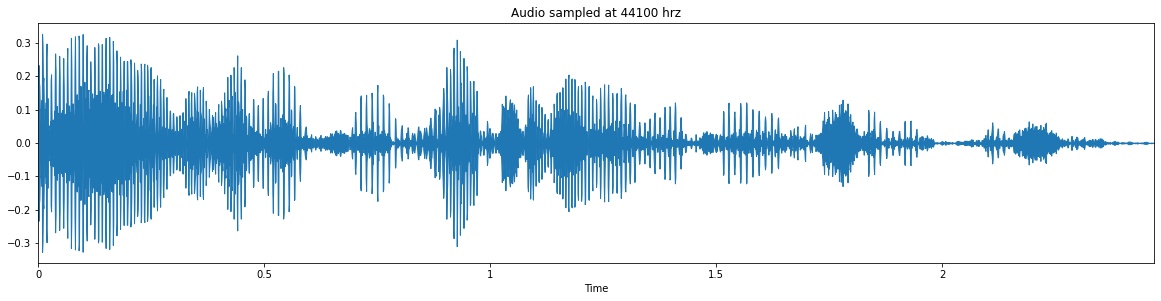

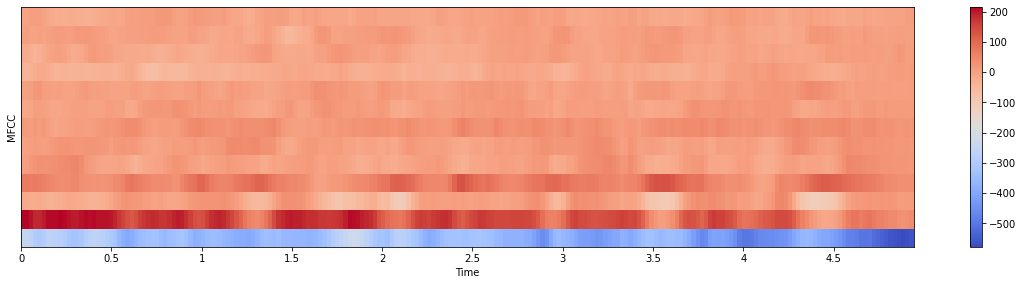

In [ ]:
path = TRAIN + '0004MN.wav' 
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveplot(X, sr=sample_rate)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

In [ ]:
# Importing required libraries 
# Keras
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other  
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
import pickle
import IPython.display as ipd  # To play sound in the notebook

In [ ]:
print(df.shape)
df.head()

(2221, 3)


,path,gender,labels
0,/content/drive/MyDrive/Mofid/train-3/0000MA.wav,male,angry
1,/content/drive/MyDrive/Mofid/train-3/0003MA.wav,male,angry
2,/content/drive/MyDrive/Mofid/train-3/0004MN.wav,male,neutral
3,/content/drive/MyDrive/Mofid/train-3/0005FS.wav,female,sad
4,/content/drive/MyDrive/Mofid/train-3/0006MA.wav,male,angry


In [ ]:
# Note this takes a couple of minutes (~10 mins) as we're iterating over 4 datasets 
#df = pd.DataFrame(columns=['feature'])
df['feature'] = ''

# loop feature extraction over the entire dataset
counter=0
for index,path in enumerate(df.path):
    X, sample_rate = librosa.load(path, 
                                  res_type='kaiser_fast',
                                  duration=2.5,
                                  sr=44100,
                                  offset=0.5)
    
    sample_rate = np.array(sample_rate)

    if len(X) == 0:
      df.loc[index, 'feature'] = np.nan
      continue


    # mean as the feature. Could do min and max etc as well. 
    mfccs = np.mean(librosa.feature.mfcc(y=X,
                                        sr=sample_rate, 
                                        n_mfcc=13), axis = 0)
    #df.loc[counter] = [mfccs]
    #counter = counter + 1   
    df.loc[index, 'feature'] = mfccs

# Check a few records to make sure its processed successfully
print(len(df))
df.head()

2221


,path,gender,labels,feature
0,/content/drive/MyDrive/Mofid/train-3/0000MA.wav,male,angry,"[-14.684470336835405, -16.71430830663182, -18...."
1,/content/drive/MyDrive/Mofid/train-3/0003MA.wav,male,angry,"[-14.073509252469744, -13.870141959261506, -15..."
2,/content/drive/MyDrive/Mofid/train-3/0004MN.wav,male,neutral,"[-1.1266312166898405, -1.1577464301440699, -2...."
3,/content/drive/MyDrive/Mofid/train-3/0005FS.wav,female,sad,"[-29.617506474008884, -28.328141724781837, -26..."
4,/content/drive/MyDrive/Mofid/train-3/0006MA.wav,male,angry,"[-9.186143207325706, -13.162997740299845, -20...."


In [ ]:
df1 = df
df1.tail()

,path,gender,labels,feature
2216,/content/drive/MyDrive/Mofid/train-3/2992MS.wav,male,sad,"[-1.6153764020845403, -0.6679562871429032, 1.0..."
2217,/content/drive/MyDrive/Mofid/train-3/2993MN.wav,male,neutral,"[-1.351588738941484, -4.285651158214117, -10.3..."
2218,/content/drive/MyDrive/Mofid/train-3/2995MN.wav,male,neutral,"[-8.55756213677822, -11.90063160819029, -16.64..."
2219,/content/drive/MyDrive/Mofid/train-3/2996FW.wav,female,surprise,"[-9.83938805000795, -10.243365265191338, -13.0..."
2220,/content/drive/MyDrive/Mofid/train-3/2999MH.wav,male,happy,"[-10.202840282320194, -9.786628581172089, -5.8..."


In [ ]:
#df1[df1.isnull().any(axis=1)]

In [ ]:
#df1.dropna(subset = ['feature'], inplace=True)
#print(df1.shape)
#df1.head()

In [ ]:
len(df2['feature'][2216])

191

In [ ]:
# Now extract the mean bands to its own feature columns
df2 = pd.concat([df1, pd.DataFrame(df1['feature'].values.tolist())],axis=1)
print(df2.shape)
df2.tail()

(2221, 220)


,path,gender,labels,feature,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,...,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215
2216,/content/drive/MyDrive/Mofid/train-3/2992MS.wav,male,sad,"[-1.6153764020845403, -0.6679562871429032, 1.0...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2217,/content/drive/MyDrive/Mofid/train-3/2993MN.wav,male,neutral,"[-1.351588738941484, -4.285651158214117, -10.3...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2218,/content/drive/MyDrive/Mofid/train-3/2995MN.wav,male,neutral,"[-8.55756213677822, -11.90063160819029, -16.64...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2219,/content/drive/MyDrive/Mofid/train-3/2996FW.wav,female,surprise,"[-9.83938805000795, -10.243365265191338, -13.0...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2220,/content/drive/MyDrive/Mofid/train-3/2999MH.wav,male,happy,"[-10.202840282320194, -9.786628581172089, -5.8...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.tail()

,path,gender,labels,feature,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,...,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215
2216,/content/drive/MyDrive/Mofid/train-3/2992MS.wav,male,sad,"[-1.6153764020845403, -0.6679562871429032, 1.0...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2217,/content/drive/MyDrive/Mofid/train-3/2993MN.wav,male,neutral,"[-1.351588738941484, -4.285651158214117, -10.3...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2218,/content/drive/MyDrive/Mofid/train-3/2995MN.wav,male,neutral,"[-8.55756213677822, -11.90063160819029, -16.64...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2219,/content/drive/MyDrive/Mofid/train-3/2996FW.wav,female,surprise,"[-9.83938805000795, -10.243365265191338, -13.0...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2220,/content/drive/MyDrive/Mofid/train-3/2999MH.wav,male,happy,"[-10.202840282320194, -9.786628581172089, -5.8...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# replace NA with 0
df = df.fillna(0)
print(df.shape)
df[:5]

In [ ]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(df.drop(['path','labels','gender','feature'],axis=1), 
                                                    df.labels, 
                                                    test_size=0.25, 
                                                    shuffle=True, 
                                                    random_state=42)

# Lets see how the data present itself before normalisation 
X_train[150:160]

In [ ]:
# Lts do data normalization 
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Check the dataset now 
X_train[150:160]

In [ ]:
# Lets few preparation steps to get it into the correct format for Keras 
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

print(X_train.shape)
print(lb.classes_)
#print(y_train[0:10])
#print(y_test[0:10])

# Pickel the lb object for future use 
filename = 'labels'
outfile = open(filename,'wb')
pickle.dump(lb,outfile)
outfile.close()

In [ ]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

In [ ]:
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(14)) # Target class number
model.add(Activation('softmax'))
# opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
# opt = keras.optimizers.Adam(lr=0.0001)
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train, batch_size=16, epochs=100, validation_data=(X_test, y_test))

In [ ]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()